In [1]:
import osmnx as ox
import geopandas as gpd
import numpy as np
import pandas as pd

# Open streetmap data quisition

This code below fetches the regional boundaries of Helsinki Espoo and Vantaa

In [2]:
city = ox.gdf_from_place('Helsinki, Finland')
ox.save_gdf_shapefile(ox.project_gdf(city), filename='Helsinki',folder='.')
city = ox.gdf_from_place('Espoo, Finland')
ox.save_gdf_shapefile(ox.project_gdf(city), filename='Espoo',folder='.')
city = ox.gdf_from_place('Vantaa, Finland')
ox.save_gdf_shapefile(ox.project_gdf(city), filename='Vantaa',folder='.')

This here fetches footprints. Usually this is used to load buildings. But here landuse is loaded instead

In [3]:
landuse = ox.footprints.footprints_from_place(place='Helsinki, Finland',footprint_type='landuse')
ox.save_gdf_shapefile(ox.project_gdf(landuse), filename='Helsinki_landuse',folder='.')
landuse = ox.footprints.footprints_from_place(place='Espoo, Finland',footprint_type='landuse')
ox.save_gdf_shapefile(ox.project_gdf(landuse), filename='Espoo_landuse',folder='.')
landuse = ox.footprints.footprints_from_place(place='Vantaa, Finland',footprint_type='landuse')
ox.save_gdf_shapefile(ox.project_gdf(landuse), filename='Vantaa_landuse',folder='.')

Now make a selection polygon for the aquistion of cycle network of osm by osmnx
Create a graph and save this as a local file (Careful this file is huge and needs time to load)

In [5]:
from geopandas import GeoSeries
import os.path

if os.path.isfile('HEL_ESP_VAN_KAU_bike_routes.graphml'): 
    G=ox.load_graphml('HEL_ESP_VAN_KAU_bike_routes.graphml',folder='.')
else:
    city1 = ox.gdf_from_place('Helsinki, Finland').geometry.unary_union
    city2 = ox.gdf_from_place('Espoo, Finland').geometry.unary_union
    city3 = ox.gdf_from_place('Vantaa, Finland').geometry.unary_union
    city4 = ox.gdf_from_place('Kauniainen, Finland').geometry.unary_union
    HEL_ESP_VAN_KAU=GeoSeries([city1,city2,city3,city4]).unary_union

    G = ox.graph_from_polygon(HEL_ESP_VAN_KAU,network_type='bike')
    G=ox.project_graph(G)
    ox.save_graphml(G, filename='HEL_ESP_VAN_KAU_bike_routes.graphml',folder='.')

Load the point data from Helsinki infoshare and remove the points from Hyvinkää and Kerava

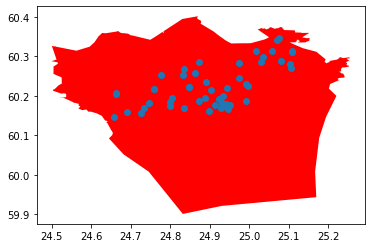

In [6]:
from scipy.spatial import Delaunay

asemat=gpd.read_file('.\Helsingin_seudun_pyörälaskennat\Helsingin_seudun_pyörälaskennat.shp')
asemat
HEL_ESP_VAN_KAU=gpd.GeoDataFrame(pd.DataFrame(data=[HEL_ESP_VAN_KAU],columns=['geometry']))
ax=HEL_ESP_VAN_KAU.plot(color='red')
asemat=asemat.loc[asemat.within(HEL_ESP_VAN_KAU.geometry[0])]
asemat.plot(ax=ax)


construct a point list and after that a delaunay triangulation to find stations near to each other


In [7]:
asemat=ox.project_gdf(asemat)

closest=[]
points=[]
for point in asemat.geometry:
    point=point.coords[:][0]
    points.append([point[0], point[1]])

points=np.array(points)
closest=ox.get_nearest_nodes(G,points[:,0],points[:,1],method='kdtree')

points[:,0]=[ G.nodes[close]['x'] for close in closest]
points[:,1]=[ G.nodes[close]['y'] for close in closest]


tri = Delaunay(points)



C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Now use networkx to find a short path between stations near each other using the triangulation

In [8]:
import networkx as nx
paths=[]
print(len(tri.simplices),end=' ')
i=0
for dntri in tri.simplices:
    dntri_close=([closest[dntri[0]],closest[dntri[1]],closest[dntri[2]]])
    path=[]
    for n in range(3):
        for m in range(3):
            path.append(nx.shortest_path(G, source=dntri_close[n], target=dntri_close[m], weight='length', method='dijkstra'))
    print(i,end=' ')
    i=i+1
    paths.append(path)

87 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 

then reconstruct a osmnx compatible graph for plotting

In [9]:
Gnew=nx.MultiDiGraph()

for path in paths:
    for path_n in path:
        for n in range(len(path_n)-1):
            Gnew.add_edge(path_n[n],path_n[n+1],**G[path_n[n]][path_n[n+1]][0])
for node in Gnew.nodes:
    Gnew.add_node(node,**G.nodes[node])


Save the simpler graph to disc and plot both the network (osmnx) and the data (mximum traffic 2018, geopandas)

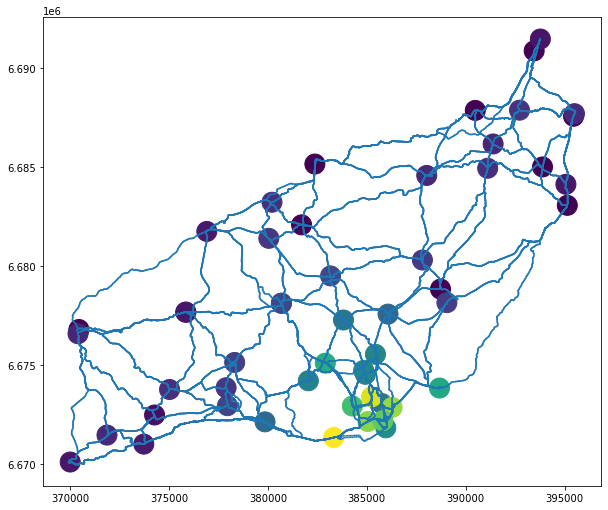

In [10]:
import matplotlib.pyplot as plt
Gnew.graph=G.graph
ox.save_graphml(Gnew, filename='HEL_ESP_VAN_KAU_bike_routes_simple.graphml',folder='.')
#ax=asemat.plot(markersize=400,column='huip_2018',figsize=[100,100])
#gdf_edges=ox.graph_to_gdfs(Gnew,edges=True,nodes=False) 
#fig,ax=ox.plot_graph_route(Gnew, paths[15][1], node_size=3)

Gnew_gdf_nodes,Gnew_gdf_edges=ox.graph_to_gdfs(Gnew)

ax=Gnew_gdf_edges.plot(figsize=[10,10])

asemat.plot(markersize=400,column='huip_2018',ax=ax)
#ax.plot(points[:,0],points[:,1],'+',markersize=400)